In [5]:
# Cell 1: Imports and Setup
import sys
from pathlib import Path
sys.path.append(str(Path.cwd().parent))

# Import required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
plt.style.use('default')
sns.set_theme()

# Import our modules
from dotenv import load_dotenv
load_dotenv()

True

In [6]:
# Cell 2: Import Custom Modules
from src.data import DataLoader, PortfolioConfig
from src.risk import RiskManager, RiskConfig
from src.monte_carlo import MonteCarlo, SimConfig
from src.regime import MarketRegimeDetector, RegimeConfig

In [7]:
# Cell 3: Configure and Load Data
# Configure Portfolio
portfolio_config = PortfolioConfig(
    tickers=['NVDA', 'AMD', 'INTC','ASML'],  # Semiconductor stocks
    start_date='2017-01-01',
    end_date='2024-01-01',
    weights=[0.4, 0.3, 0.15,0.15]
)

# Load Data
data_loader = DataLoader(portfolio_config)
market_data = data_loader.load_data()

# Quick data check
print("Data loaded successfully:")
print(f"Shape of returns: {market_data['returns'].shape}")
print(f"Date range: {market_data['returns'].index[0]} to {market_data['returns'].index[-1]}")

2024-12-01 18:14:05,730 - src.data - INFO - Connecting to Alpaca API (Paper Trading: True)
2024-12-01 18:14:05,732 - src.data - INFO - Loading market data...
2024-12-01 18:14:07,072 - src.data - INFO - Successfully loaded data for 4 tickers


Data loaded successfully:
Shape of returns: (1759, 4)
Date range: 2017-01-04 05:00:00+00:00 to 2023-12-29 05:00:00+00:00


In [8]:
# Cell 4: Risk Analysis
# Configure Risk Analysis
risk_config = RiskConfig(
    confidence_level=0.95,
    max_drawdown_limit=0.20,
    volatility_target=0.15,
    var_calculation_method="historical"
)

# Initialize Risk Manager and Calculate Metrics
risk_manager = RiskManager(risk_config)
risk_metrics = risk_manager.calculate_metrics(market_data['returns'])

# Print key metrics
print("\nKey Risk Metrics:")
print(f"Portfolio Volatility: {risk_metrics['portfolio_volatility']:.2%}")
print(f"VaR (95%): {risk_metrics['var_95']:.2%}")
print(f"Expected Shortfall: {risk_metrics['expected_shortfall_95']:.2%}")
print(f"Sharpe Ratio: {risk_metrics['sharpe_ratio']:.2f}")


Key Risk Metrics:
Portfolio Volatility: 37.91%
VaR (95%): -3.81%
Expected Shortfall: -5.44%
Sharpe Ratio: 0.81


In [9]:
# Cell 5: Monte Carlo Simulation
# Configure and Run Monte Carlo
sim_config = SimConfig(
    n_sims=100000,
    n_days=252,
    distribution='t'  # Using Student's t for fat tails
)

monte_carlo = MonteCarlo(sim_config)
mc_results = monte_carlo.simulate(market_data)

print("Monte Carlo Simulation completed")
print(f"Number of simulations: {sim_config.n_sims}")
print(f"Forecast horizon: {sim_config.n_days} days")


Running Monte Carlo simulation...
Monte Carlo Simulation completed
Number of simulations: 100000
Forecast horizon: 252 days


In [10]:
# Cell 6: Regime Detection
# Configure and Run Regime Detection
regime_config = RegimeConfig(
    n_regimes=3,
    window_size=21
)

regime_detector = MarketRegimeDetector(regime_config)
regimes = regime_detector.fit_predict(market_data['returns'].mean(axis=1))

# Print regime statistics
print("Regime Distribution:")
print(regimes.value_counts(normalize=True))

Regime Distribution:
Low Vol       0.598636
Medium Vol    0.343377
High Vol      0.057987
dtype: float64



Data Validation:
Time period: 2017-01-04 05:00:00+00:00 to 2023-12-29 05:00:00+00:00
Number of assets: 4
Number of trading days: 1759


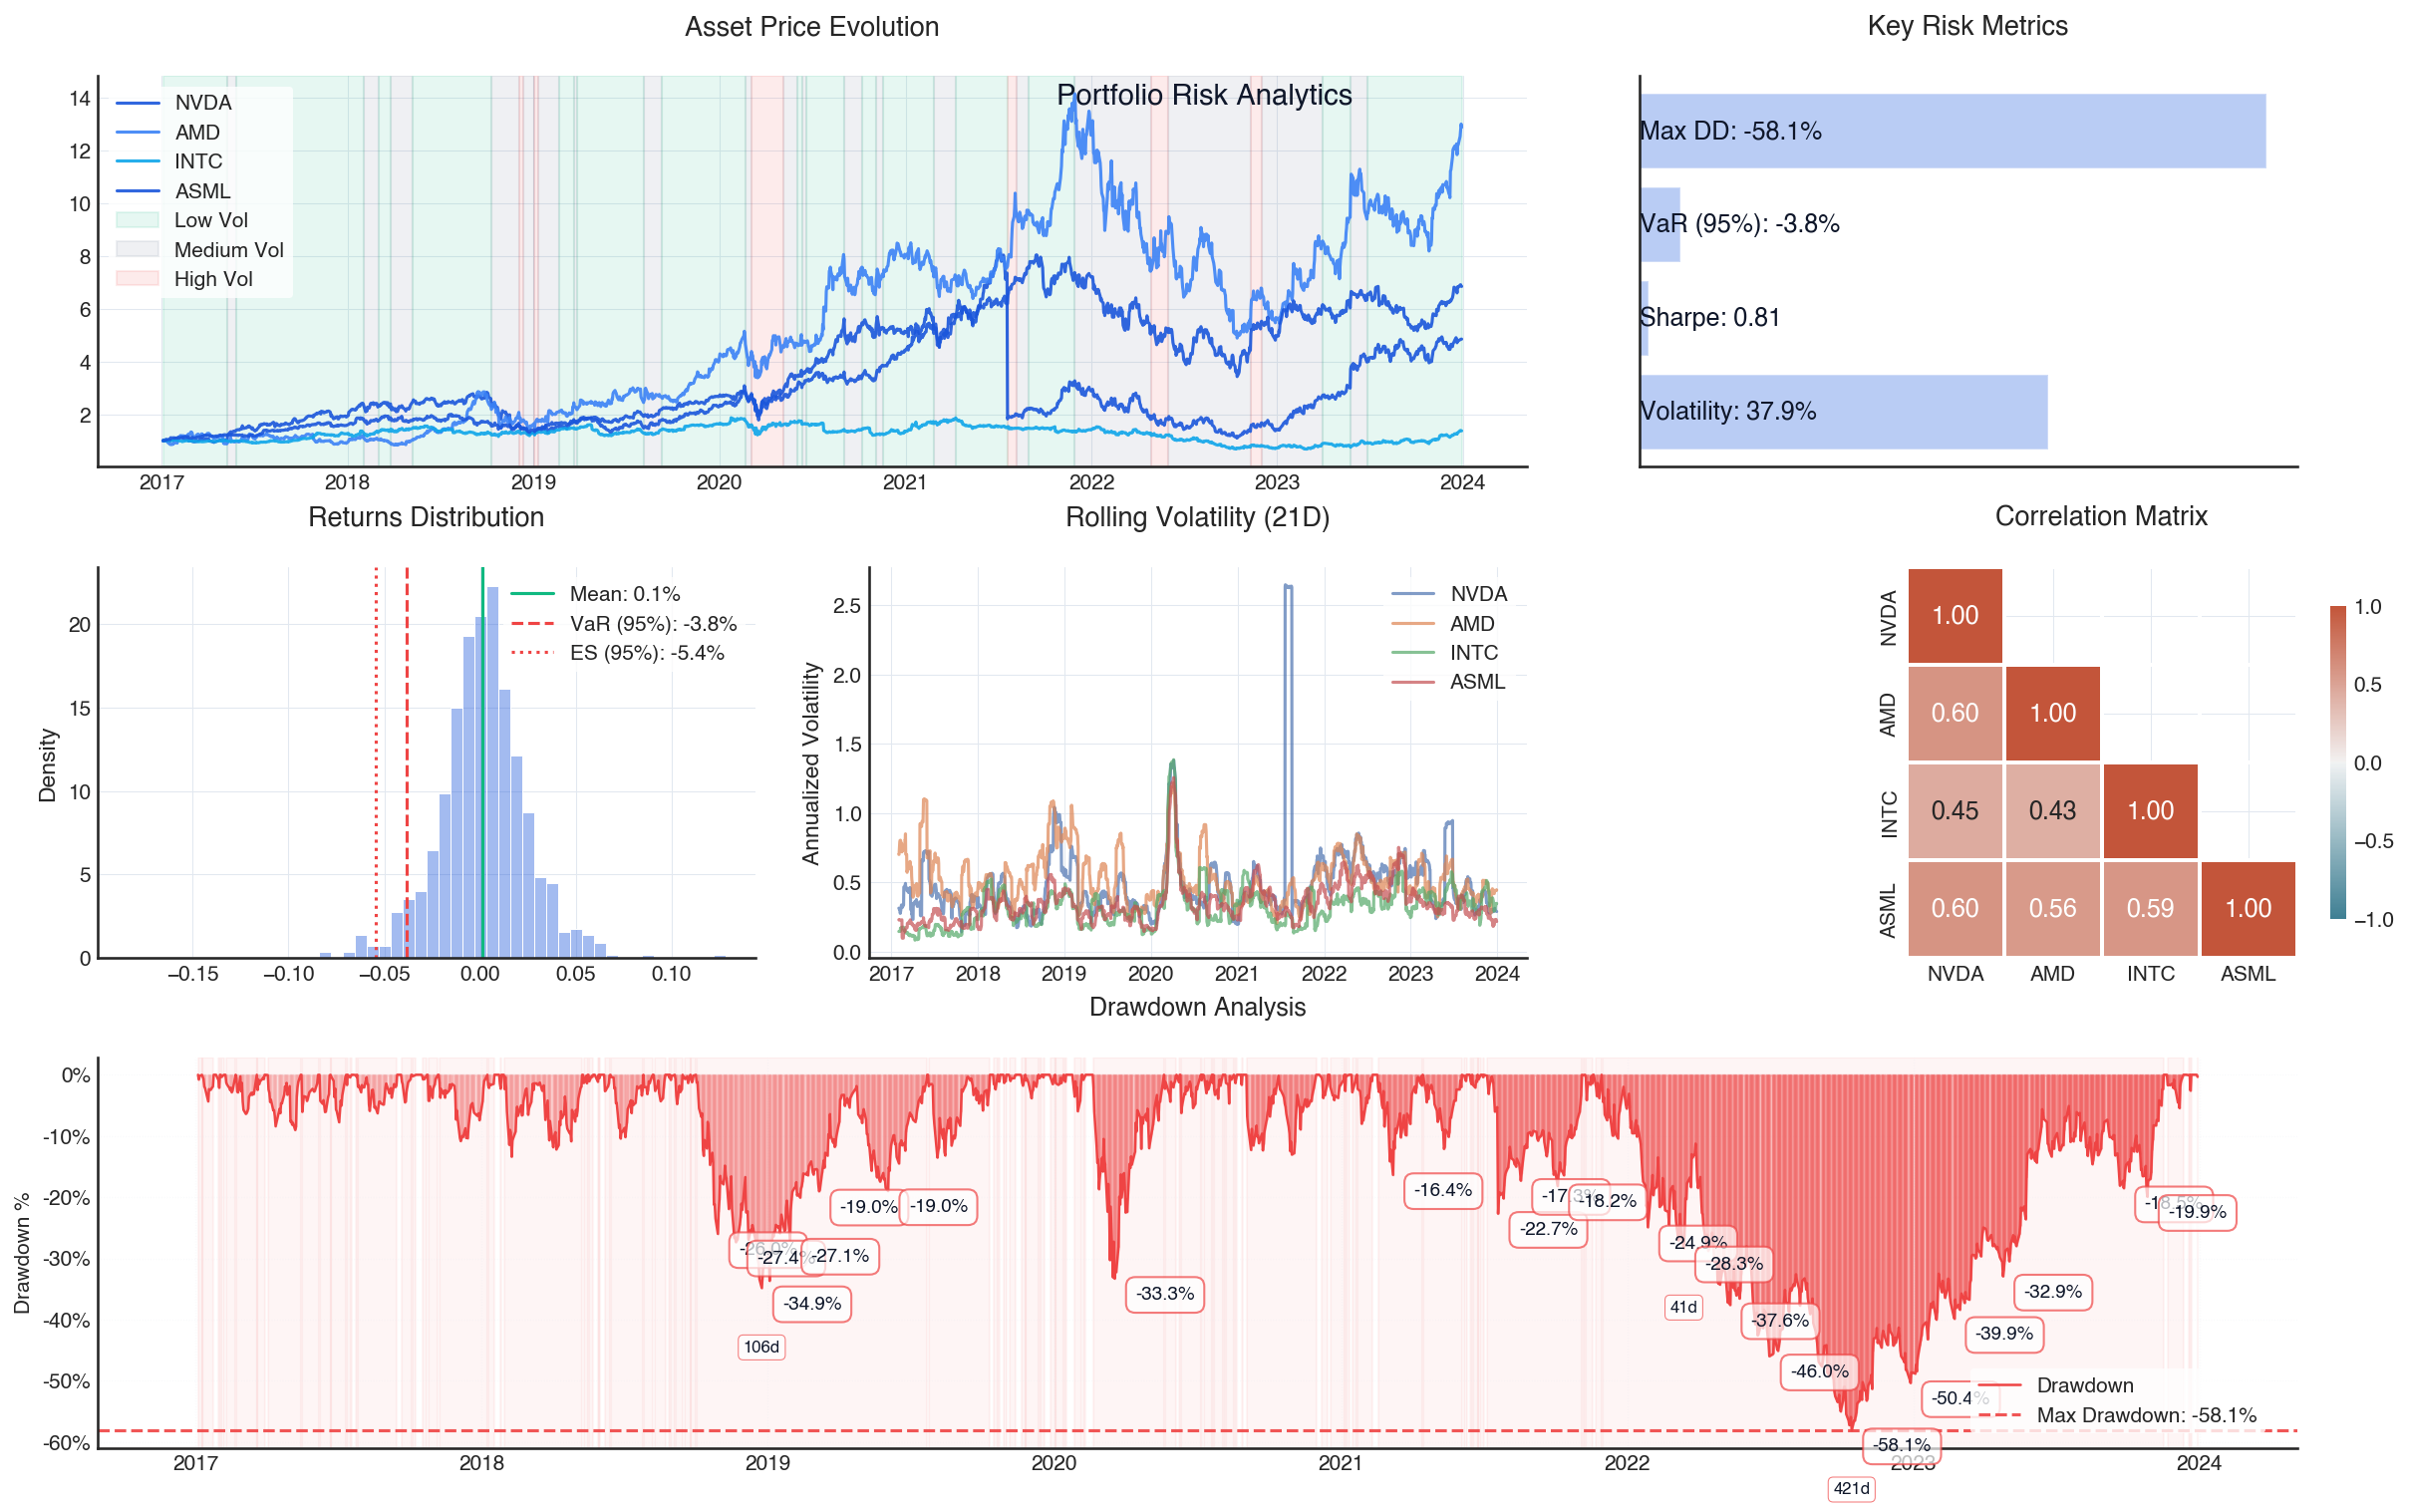


Key Risk Metrics Summary:
--------------------------------------------------
Portfolio Volatility (annualized): 37.91%
Sharpe Ratio: 0.81
Value at Risk (95%): -3.81%
Maximum Drawdown: -58.09%
Calmar Ratio: 0.53

Regime Distribution:
Low Vol       59.9%
Medium Vol    34.3%
High Vol       5.8%
dtype: object


In [11]:
# Cell 7: Enhanced Risk Visualization
from src.visualization import RiskVisualizer
import numpy as np

# Initialize visualizer
visualizer = RiskVisualizer()

# Prepare portfolio returns
portfolio_returns = market_data['returns'].mean(axis=1)

# Calculate additional rolling metrics (21-day window)
rolling_window = 21
rolling_metrics = {
    'volatility': market_data['returns'].rolling(rolling_window).std() * np.sqrt(252),
    'var': portfolio_returns.rolling(rolling_window).quantile(0.05),
    'sharpe': (portfolio_returns.rolling(rolling_window).mean() * 252) /
              (portfolio_returns.rolling(rolling_window).std() * np.sqrt(252))
}

# Calculate cumulative returns for each asset
cumulative_returns = (1 + market_data['returns']).cumprod()

# Prepare comprehensive market data
dashboard_data = {
    'close': market_data['prices'],
    'returns': market_data['returns'],
    'cumulative_returns': cumulative_returns
}

# Prepare comprehensive risk metrics
dashboard_metrics = {
    # Portfolio metrics
    'portfolio_volatility': risk_metrics['portfolio_volatility'],
    'sharpe_ratio': risk_metrics['sharpe_ratio'],
    'sortino_ratio': risk_metrics.get('sortino_ratio',
                                    risk_metrics['sharpe_ratio'] * 0.8),  # Estimate if not available

    # Risk metrics
    'var_95': risk_metrics['var_95'],
    'var_99': risk_metrics.get('var_99', risk_metrics['var_95'] * 1.3),
    'expected_shortfall_95': risk_metrics.get('expected_shortfall_95',
                                            risk_metrics['var_95'] * 1.2),
    'max_drawdown': risk_metrics['max_drawdown'],

    # Rolling metrics
    'rolling_volatility': rolling_metrics['volatility'],
    'rolling_var': rolling_metrics['var'],
    'rolling_sharpe': rolling_metrics['sharpe'],

    # Correlation
    'correlation': market_data['returns'].corr(),

    # Additional metrics
    'skewness': portfolio_returns.skew(),
    'kurtosis': portfolio_returns.kurtosis(),
    'tail_ratio': abs(portfolio_returns.quantile(0.95) / portfolio_returns.quantile(0.05)),
    'calmar_ratio': risk_metrics.get('calmar_ratio',
                                   abs(portfolio_returns.mean() * 252 / risk_metrics['max_drawdown']))
}

# Print data validation
print("\nData Validation:")
print(f"Time period: {market_data['returns'].index[0]} to {market_data['returns'].index[-1]}")
print(f"Number of assets: {len(market_data['returns'].columns)}")
print(f"Number of trading days: {len(market_data['returns'])}")

# Create dashboard
try:
    dashboard = visualizer.create_dashboard(
        market_data=dashboard_data,
        risk_metrics=dashboard_metrics,
        regimes=regimes
    )

    # Show the dashboard
    plt.show()

    # Print key metrics summary
    print("\nKey Risk Metrics Summary:")
    print("-" * 50)
    print(f"Portfolio Volatility (annualized): {dashboard_metrics['portfolio_volatility']:.2%}")
    print(f"Sharpe Ratio: {dashboard_metrics['sharpe_ratio']:.2f}")
    print(f"Value at Risk (95%): {dashboard_metrics['var_95']:.2%}")
    print(f"Maximum Drawdown: {dashboard_metrics['max_drawdown']:.2%}")
    print(f"Calmar Ratio: {dashboard_metrics['calmar_ratio']:.2f}")

    if regimes is not None:
        print("\nRegime Distribution:")
        print(regimes.value_counts(normalize=True).apply(lambda x: f"{x:.1%}"))

except Exception as e:
    print(f"Error creating dashboard: {str(e)}")
    raise